<a href="https://colab.research.google.com/github/codeyson/CPE-313/blob/main/Hands_on_Activity_4_1_Introduction_to_Pytorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import torch
import os
from torch.utils.data import  DataLoader
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image_tensor = read_image(img_path)
        # Convert the PyTorch tensor (C, H, W) to a PIL Image (H, W, C) for standard torchvision transforms.
        # This ensures transforms like ToTensor properly scale and convert type.
        # The .numpy() call is essential here for Image.fromarray.
        image = Image.fromarray(image_tensor.permute(1, 2, 0).numpy())

        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [61]:
from torchvision import transforms
from torchvision.transforms import Lambda

transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 pixels
    transforms.ToTensor()          # Convert images to PyTorch tensors
])

target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

dataset = CustomImageDataset('/content/drive/MyDrive/TIP Files/32Sx/CPE 313 (Deep Learning with Python)/Hands-on Activity 4.1 Introduction to Pytorch /data/bike_car_labels.csv',
                             '/content/drive/MyDrive/TIP Files/32Sx/CPE 313 (Deep Learning with Python)/Hands-on Activity 4.1 Introduction to Pytorch /data/images',
                             transform=transform, target_transform=target_transform)

In [62]:
print(f"Length of dataset: {len(dataset)}")
training_data, test_data = torch.utils.data.random_split(dataset, [7, 2])

Length of dataset: 9


In [63]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([7, 3, 224, 224])
Labels batch shape: torch.Size([7, 10])


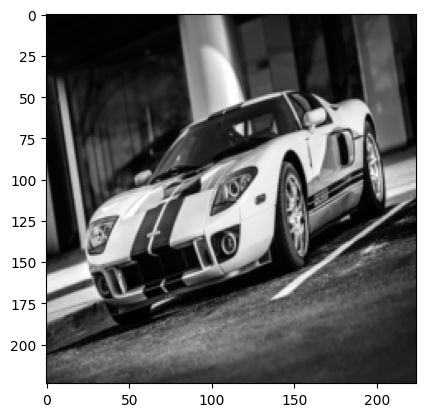

Label: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [64]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
import matplotlib.pyplot as plt
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

## Build Model

In [65]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [66]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [67]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 224 * 224, 512), # Corrected input features
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [68]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [69]:
X = torch.rand(1, 3, 224, 224, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4])


In [70]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 150528]) | Values : tensor([[ 0.0004,  0.0005, -0.0019,  ..., -0.0023, -0.0016,  0.0011],
        [ 0.0005, -0.0019,  0.0004,  ...,  0.0003, -0.0016,  0.0006]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0017,  0.0010], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0073,  0.0156,  0.0416,  ...,  0.0082,  0.0216,  0.0107],
        [-0.0250, -0.0245, -0.0172,  ...,  0.0216,  0.0284, -0.0333]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.b

### Optimization

In [71]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [72]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [73]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [74]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [75]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312607  [    7/    7]
Test Error: 
 Accuracy: 50.0%, Avg loss: 2.197778 

Epoch 2
-------------------------------
loss: 2.103373  [    7/    7]
Test Error: 
 Accuracy: 50.0%, Avg loss: 2.110139 

Epoch 3
-------------------------------
loss: 1.957183  [    7/    7]
Test Error: 
 Accuracy: 50.0%, Avg loss: 2.028878 

Epoch 4
-------------------------------
loss: 1.821328  [    7/    7]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.949056 

Epoch 5
-------------------------------
loss: 1.690580  [    7/    7]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.870700 

Done!


In [76]:
print("Evaluating model performance:")
test_loop(test_dataloader, model, loss_fn)

Evaluating model performance:
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.870700 



### Conclusion

In this laboratory activity, I followed python notebooks from the module. I created a custom dataset that should classify if the image is a motorcyle or car. However, my model got only up to 50% ccuracy. In order to make this working properly, I use AI to ensure the input features are match. My main goal here is to get a grasp of pytorch by myself even with low accuracy since my created custom dataset is just consist of 10 images in total.